Ladda de nödvändiga paketen och läs in datat.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
data = [(0,20), (0,20), (0,20), (0,20), (0,20), (0,20), (0,20), (0,19), (0,19),  (0,19),
        (0,19), (0,18), (0,18), (0,17), (1,20), (1,20), (1,20), (1,20), (1,19), (1,19),
        (1,18), (1,18), (2,25), (2,24), (2,23), (2,20), (2,20), (2,20), (2,20), (2,20),
        (2,20), (1,10), (5,49), (2,19), (5,46), (3,27), (2,17), (7,49), (7,47), (3,20),
        (3,20), (2,13), (9,48), (10,50), (4,20), (4,20), (4,20), (4,20), (4,20), (4,20),
        (4,20), (10,48), (4,19), (4,19), (4,19), (5,22), (11,46), (12,49),(5,20), (5,20),
        (6,23), (5,19), (6,22), (6,20), (6,20), (6,20), (16,52), (15,47), (15,46), (9,24),
        (4, 14)]

Vi använder den icke-informativa apriorifördelningen $f(\alpha, \beta) \propto (\alpha + \beta)^{-5/2}$. För att undvika problem med under- och overflow arbetar vi med logaritmer av täthetsfunktionerna. Dessa kan sedan exponentieras för att ta fram täthetsfunktionernas värden.

In [3]:
def log_prior(alpha, beta):
    return -5 / 2 * np.log(alpha + beta)

In [4]:
# Använd den inbyggda loggamma-funktionen istället för att ta np.log(gamma(x)) då detta också kan leda till overflow.
from scipy.special import loggamma

In [5]:
def log_posterior(alpha, beta):
    log_p = log_prior(alpha, beta)
    
    for x, n in data:
        log_p += loggamma(alpha + beta) - (loggamma(alpha) + loggamma(beta))
        log_p += loggamma(alpha + x) + loggamma(beta + n - x) - loggamma(alpha + beta + n)
        
    return log_p

Vi plottar aposteriorifördelningen för att bilda en uppfattning om hur hyperparametrarna beter sig.

In [6]:
alpha_grid = np.linspace(0.01, 5, 100)
beta_grid = np.linspace(0.01, 25, 100)

In [7]:
log_posterior_grid = [[log_posterior(alpha, beta) for alpha in alpha_grid] for beta in beta_grid]

# För att undvika underflow när vi exponentierar log-täthetsfunktionen subtraherar vi först det största värdet,
# vilket gör att det största värdet efter exponentiering alltid är ett.
posterior_grid = np.exp(log_posterior_grid - np.max(log_posterior_grid))

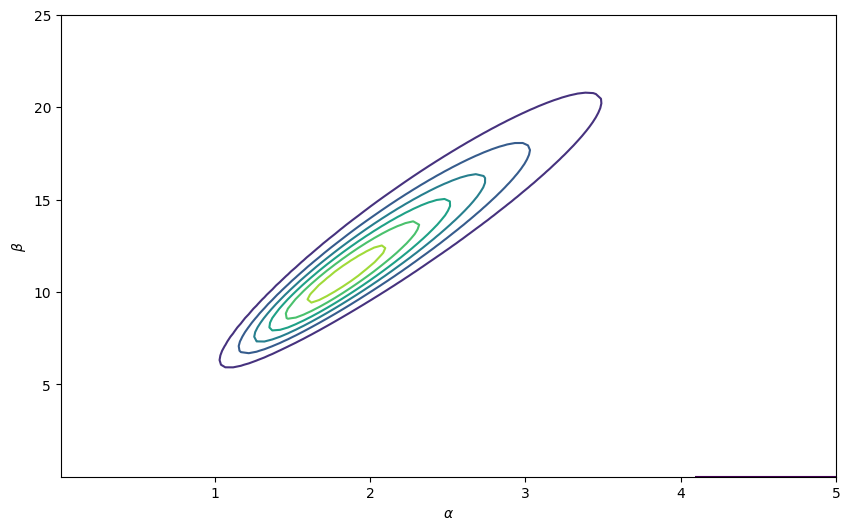

In [8]:
plt.figure(figsize=(10, 6))
plt.contour(alpha_grid, beta_grid, posterior_grid)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.show()

För att göra konkreta beräkningar behöver vi simulera från aposteriorifördelningen. Detta kan göras med hjälp av metropolisalgoritmen som vi har sett tidigare. Några saker att tänka på här är att $\alpha$ och $\beta$ båda ska vara positiva värden, så när vi definierar hoppfördelningen gör vi detta på logaritmen av parametrarna och exponentierar efteråt.

In [9]:
delta = 0.1

k = 8000

params = [np.exp(stats.cauchy.rvs(size=2))]

for _ in range(k - 1):
    last = params[-1]
    
    log_last = np.log(last)
    log_proposal = log_last + delta * stats.norm.rvs(size=2)
    proposal = np.exp(log_proposal)
    
    r = np.exp(log_posterior(*proposal) - log_posterior(*last))
    
    u = stats.uniform.rvs()
    
    if u < min(1, r):
        params.append(proposal)
    else:
        params.append(last)
        
params = np.array(params)

För att undersöka konvergensen plottar vi parametervärdena och de löpande medelvärdena.

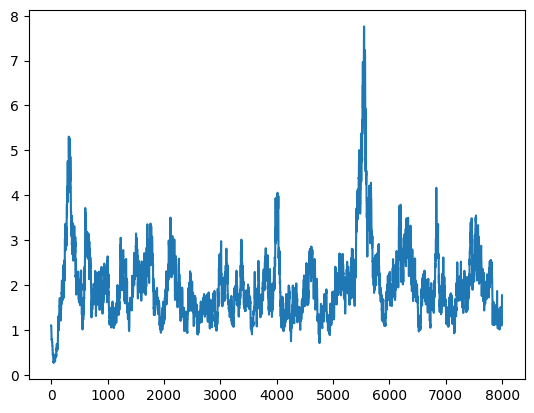

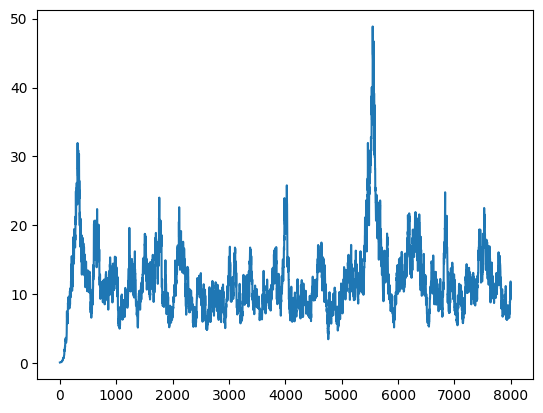

In [10]:
plt.plot(params[:, 0])
plt.show()

plt.plot(params[:, 1])
plt.show()

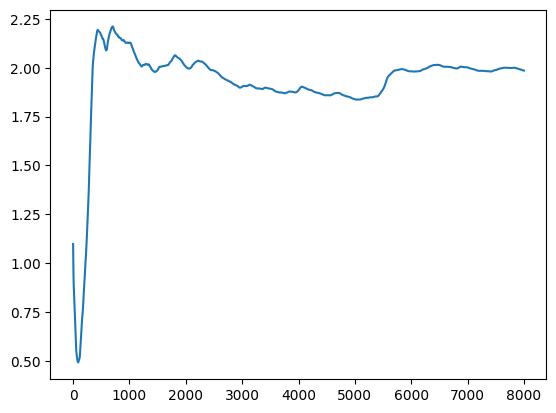

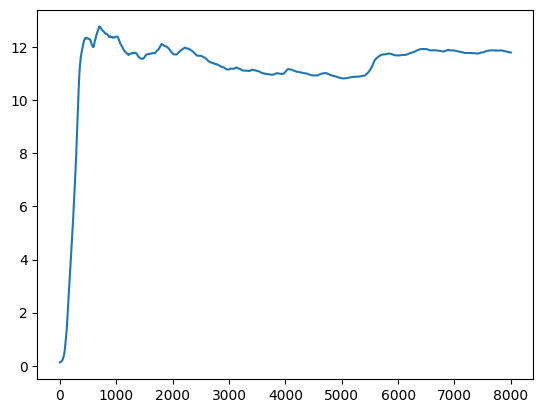

In [11]:
plt.plot(np.cumsum(params[:, 0]) / np.arange(1, len(params) + 1))
plt.show()

plt.plot(np.cumsum(params[:, 1]) / np.arange(1, len(params) + 1))
plt.show()

Om allt ser bra ut exraherar vi andra hälften av datat då vi borde ha hyfsat bra konvergens. Vi kan plotta dessa utfall för att jämföra med täthetsfunktionen vi såg innan.

In [12]:
params = params[k // 2:]
m = k // 2
params = params[m // 2:] #take the last 2000
print(len(params))

2000


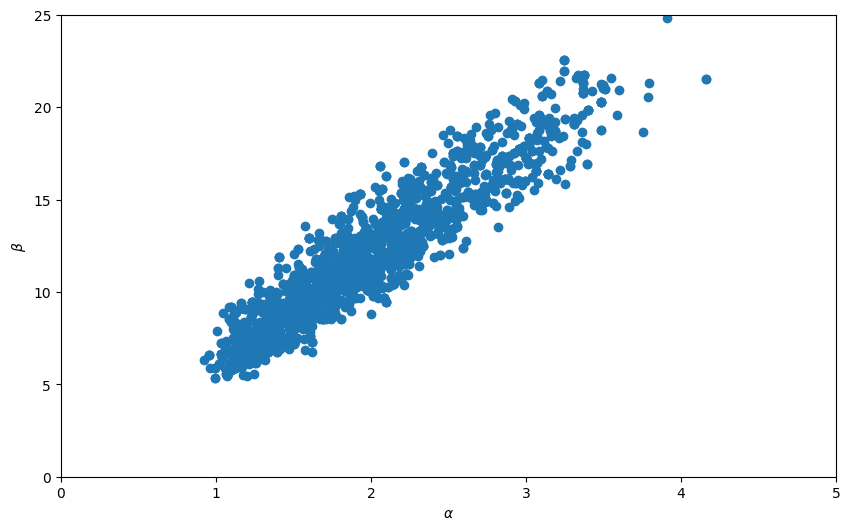

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(params[:, 0], params[:, 1])
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.xlim(0, 5)
plt.ylim(0, 25)
plt.show()

Nu när vi har ett antal utfall av $A$ och $B$ kan vi approximera deras aposterioriväntevärden genom aritmetiska medelvärden.

In [14]:
alpha_est = np.mean(params[:, 0])
beta_est = np.mean(params[:, 1])

print(f"{alpha_est}, {beta_est}")

1.9989010265829614, 12.122169213943577


Vi kan också simulera utfall av $\Theta$ givet datat genom att använda de genererade utfallen av $A, B$ och den betingade fördelningen $\Theta \mid A = \alpha, B = \beta \sim \operatorname{Beta}(\alpha, \beta)$.

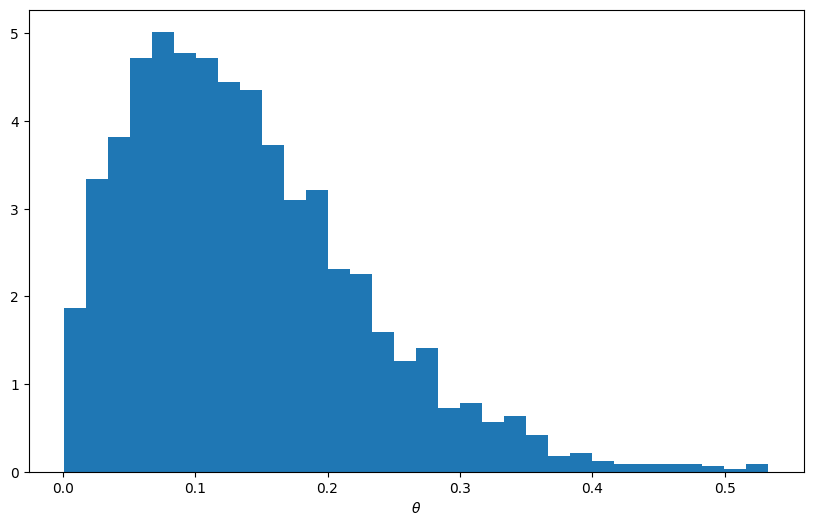

In [15]:
thetas = [stats.beta.rvs(alpha, beta) for alpha, beta in params]

plt.figure(figsize=(10, 6))
plt.hist(thetas, 32, density=True)
plt.xlabel(r"$\theta$")
plt.show()

Med hjälp av lagarna om total förväntan och total varians kan vi beräkna $\text{E}[\Theta \mid \boldsymbol{X} = \boldsymbol{x}]$ och $\text{Var}[\Theta \mid \boldsymbol{X} = \boldsymbol{x}]$.

In [16]:
theta_means = [stats.beta.mean(alpha, beta) for alpha, beta in params]
theta_vars = [stats.beta.var(alpha, beta) for alpha, beta in params]

theta_mean = np.mean(theta_means)
theta_var = np.mean(theta_vars) + np.var(theta_means)

print(f"{theta_mean}, {theta_var}")

0.14224474029296083, 0.00892112162508639


För vårt eget experiment (#71) kan vi använda den betingade aposteriorifördelningen för $\Theta_{71}$ för att ta fram aposterioriväntevärde och aposterioristandardavvikelse på samma sätt.

In [17]:
x71, n71 = data[70]

theta71_means = [stats.beta.mean(alpha + x71, beta + n71 - x71) for alpha, beta in params]
theta71_vars = [stats.beta.var(alpha + x71, beta + n71 - x71) for alpha, beta in params]

theta71_mean = np.mean(theta71_means)
theta71_var = np.mean(theta71_vars) + np.var(theta71_means)
theta71_std = np.sqrt(theta71_var)

print(f"{theta71_mean}, {theta71_std}")

0.2149962197911923, 0.07819053903487924


Vi kan repetera samma beräkning för alla experiment i vår datamängd och jämföra dessa med skattningarna som fås om vi tar varje experiment för sig med en icke-informativ apriorifördelning.

In [18]:
theta_ests_single = []
theta_ests_hierarchy = []

for x, n in data:
    theta_est_single = x / n
    theta_ests_single.append(theta_est_single)
    
    theta_est_hierarchy = np.mean([stats.beta.mean(alpha + x, beta + n - x) for alpha, beta in params])
    theta_ests_hierarchy.append(theta_est_hierarchy)

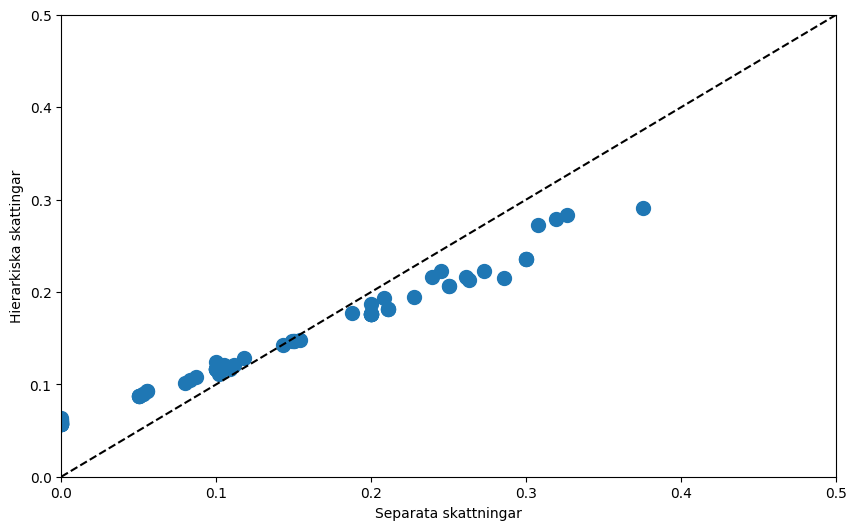

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(theta_ests_single, theta_ests_hierarchy, s=100)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.xlabel("Separata skattningar")
plt.ylabel("Hierarkiska skattingar")
plt.show()